In [1]:
%matplotlib inline


Speech Command Recognition with torchaudio
******************************************

This tutorial will show you how to correctly format an audio dataset and
then train/test an audio classifier network on the dataset.

Colab has GPU option available. In the menu tabs, select “Runtime” then
“Change runtime type”. In the pop-up that follows, you can choose GPU.
After the change, your runtime should automatically restart (which means
information from executed cells disappear).

First, let’s import the common torch packages such as
`torchaudio <https://github.com/pytorch/audio>`__ that can be installed
by following the instructions on the website.




In [2]:
# Uncomment the following line to run in Google Colab

# CPU:
# !pip install torch==1.7.0+cpu torchvision==0.8.1+cpu torchaudio==0.7.0 -f https://download.pytorch.org/whl/torch_stable.html

# GPU:
# !pip install torch==1.7.0+cu101 torchvision==0.8.1+cu101 torchaudio==0.7.0 -f https://download.pytorch.org/whl/torch_stable.html

# For interactive demo at the end:
# !pip install pydub
import os 

os.environ['CUDA_VISIBLE_DEVICES'] = "0"
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchaudio

import matplotlib.pyplot as plt
import IPython.display as ipd
from tqdm.notebook import tqdm

Let’s check if a CUDA GPU is available and select our device. Running
the network on a GPU will greatly decrease the training/testing runtime.




In [3]:


print(torch.cuda.device_count())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

1
cuda


Importing the Dataset
---------------------

We use torchaudio to download and represent the dataset. Here we use
`SpeechCommands <https://arxiv.org/abs/1804.03209>`__, which is a
datasets of 35 commands spoken by different people. The dataset
``SPEECHCOMMANDS`` is a ``torch.utils.data.Dataset`` version of the
dataset. In this dataset, all audio files are about 1 second long (and
so about 16000 time frames long).

The actual loading and formatting steps happen when a data point is
being accessed, and torchaudio takes care of converting the audio files
to tensors. If one wants to load an audio file directly instead,
``torchaudio.load()`` can be used. It returns a tuple containing the
newly created tensor along with the sampling frequency of the audio file
(16kHz for SpeechCommands).

Going back to the dataset, here we create a subclass that splits it into
standard training, validation, testing subsets.




In [4]:
from torchaudio.datasets import SPEECHCOMMANDS
import os


class SubsetSC(SPEECHCOMMANDS):
    def __init__(self, subset: str = None):
        super().__init__("./", download=True)

        def load_list(filename):
            filepath = os.path.join(self._path, filename)
            with open(filepath) as fileobj:
                return [os.path.join(self._path, line.strip()) for line in fileobj]

        if subset == "validation":
            self._walker = load_list("validation_list.txt")
        elif subset == "testing":
            self._walker = load_list("testing_list.txt")
        elif subset == "training":
            excludes = load_list("validation_list.txt") + load_list("testing_list.txt")
            excludes = set(excludes)
            self._walker = [w for w in self._walker if w not in excludes]


# Create training and testing split of the data. We do not use validation in this tutorial.
train_set = SubsetSC("training")
test_set = SubsetSC("testing")

waveform, sample_rate, label, speaker_id, utterance_number = train_set[0]

A data point in the SPEECHCOMMANDS dataset is a tuple made of a waveform
(the audio signal), the sample rate, the utterance (label), the ID of
the speaker, the number of the utterance.




Shape of waveform: torch.Size([1, 16000])
Sample rate of waveform: 16000


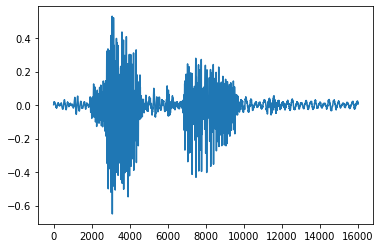

In [5]:
waveform, sample_rate, label, speaker_id, utterance_number = train_set[50]
print("Shape of waveform: {}".format(waveform.size()))
print("Sample rate of waveform: {}".format(sample_rate))

plt.plot(waveform.t().numpy());

Let’s find the list of labels available in the dataset.




In [6]:
labels = sorted(list(set(datapoint[2] for datapoint in train_set)))
labels

['backward',
 'bed',
 'bird',
 'cat',
 'dog',
 'down',
 'eight',
 'five',
 'follow',
 'forward',
 'four',
 'go',
 'happy',
 'house',
 'learn',
 'left',
 'marvin',
 'nine',
 'no',
 'off',
 'on',
 'one',
 'right',
 'seven',
 'sheila',
 'six',
 'stop',
 'three',
 'tree',
 'two',
 'up',
 'visual',
 'wow',
 'yes',
 'zero']

The 35 audio labels are commands that are said by users. The first few
files are people saying “marvin”.




In [7]:
waveform_first, *_ = train_set[0]
ipd.Audio(waveform_first.numpy(), rate=sample_rate)

waveform_second, *_ = train_set[1]
ipd.Audio(waveform_second.numpy(), rate=sample_rate)

The last file is someone saying “visual”.




In [8]:
waveform_last, *_ = train_set[-1]
ipd.Audio(waveform_last.numpy(), rate=sample_rate)

Formatting the Data
-------------------

This is a good place to apply transformations to the data. For the
waveform, we downsample the audio for faster processing without losing
too much of the classification power.

We don’t need to apply other transformations here. It is common for some
datasets though to have to reduce the number of channels (say from
stereo to mono) by either taking the mean along the channel dimension,
or simply keeping only one of the channels. Since SpeechCommands uses a
single channel for audio, this is not needed here.




In [9]:
new_sample_rate = 8000
transform = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=new_sample_rate)
transformed = transform(waveform)

ipd.Audio(transformed.numpy(), rate=new_sample_rate)

We are encoding each word using its index in the list of labels.




In [10]:
def label_to_index(word):
    # Return the position of the word in labels
    return torch.tensor(labels.index(word))


def index_to_label(index):
    # Return the word corresponding to the index in labels
    # This is the inverse of label_to_index
    return labels[index]


word_start = "yes"
index = label_to_index(word_start)
word_recovered = index_to_label(index)

print(word_start, "-->", index, "-->", word_recovered)

yes --> tensor(33) --> yes


To turn a list of data point made of audio recordings and utterances
into two batched tensors for the model, we implement a collate function
which is used by the PyTorch DataLoader that allows us to iterate over a
dataset by batches. Please see `the
documentation <https://pytorch.org/docs/stable/data.html#working-with-collate-fn>`__
for more information about working with a collate function.

In the collate function, we also apply the resampling, and the text
encoding.




In [11]:
def pad_sequence(batch):
    # Make all tensor in a batch the same length by padding with zeros
    batch = [item.t() for item in batch]
    batch = torch.nn.utils.rnn.pad_sequence(batch, batch_first=True, padding_value=0.)
    return batch.permute(0, 2, 1)


def collate_fn(batch):

    # A data tuple has the form:
    # waveform, sample_rate, label, speaker_id, utterance_number

    tensors, targets = [], []

    # Gather in lists, and encode labels as indices
    for waveform, _, label, *_ in batch:
        tensors += [waveform]
        targets += [label_to_index(label)]

    # Group the list of tensors into a batched tensor
    tensors = pad_sequence(tensors)
    targets = torch.stack(targets)

    return tensors, targets


batch_size = 256

if device == "cuda":
    num_workers = 1
    pin_memory = True
else:
    num_workers = 0
    pin_memory = False

train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)
test_loader = torch.utils.data.DataLoader(
    test_set,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)

Define the Network
------------------

For this tutorial we will use a convolutional neural network to process
the raw audio data. Usually more advanced transforms are applied to the
audio data, however CNNs can be used to accurately process the raw data.
The specific architecture is modeled after the M5 network architecture
described in `this paper <https://arxiv.org/pdf/1610.00087.pdf>`__. An
important aspect of models processing raw audio data is the receptive
field of their first layer’s filters. Our model’s first filter is length
80 so when processing audio sampled at 8kHz the receptive field is
around 10ms (and at 4kHz, around 20 ms). This size is similar to speech
processing applications that often use receptive fields ranging from
20ms to 40ms.




In [12]:
class M5(nn.Module):
    def __init__(self, n_input=1, n_output=35, stride=16, n_channel=32):
        super().__init__()
        self.conv1 = nn.Conv1d(n_input, n_channel, kernel_size=80, stride=stride)
        self.bn1 = nn.BatchNorm1d(n_channel)
        self.pool1 = nn.MaxPool1d(4)
        self.conv2 = nn.Conv1d(n_channel, n_channel, kernel_size=3)
        self.bn2 = nn.BatchNorm1d(n_channel)
        self.pool2 = nn.MaxPool1d(4)
        self.conv3 = nn.Conv1d(n_channel, 2 * n_channel, kernel_size=3)
        self.bn3 = nn.BatchNorm1d(2 * n_channel)
        self.pool3 = nn.MaxPool1d(4)
        self.conv4 = nn.Conv1d(2 * n_channel, 2 * n_channel, kernel_size=3)
        self.bn4 = nn.BatchNorm1d(2 * n_channel)
        self.pool4 = nn.MaxPool1d(4)
        self.fc1 = nn.Linear(2 * n_channel, n_output)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(self.bn1(x))
        x = self.pool1(x)
        x = self.conv2(x)
        x = F.relu(self.bn2(x))
        x = self.pool2(x)
        x = self.conv3(x)
        x = F.relu(self.bn3(x))
        x = self.pool3(x)
        x = self.conv4(x)
        x = F.relu(self.bn4(x))
        x = self.pool4(x)
        x = F.avg_pool1d(x, x.shape[-1])
        x = x.permute(0, 2, 1)
        x = self.fc1(x)
        return F.log_softmax(x, dim=2)


model = M5(n_input=transformed.shape[0], n_output=len(labels))
model.to(device)
print(model)


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


n = count_parameters(model)
print("Number of parameters: %s" % n)

M5(
  (conv1): Conv1d(1, 32, kernel_size=(80,), stride=(16,))
  (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(32, 32, kernel_size=(3,), stride=(1,))
  (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv1d(32, 64, kernel_size=(3,), stride=(1,))
  (bn3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv1d(64, 64, kernel_size=(3,), stride=(1,))
  (bn4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool4): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=64, out_features=35, bias=True)
)
Numbe

We will use the same optimization technique used in the paper, an Adam
optimizer with weight decay set to 0.0001. At first, we will train with
a learning rate of 0.01, but we will use a ``scheduler`` to decrease it
to 0.001 during training after 20 epochs.




In [13]:
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)  # reduce the learning after 20 epochs by a factor of 10

Training and Testing the Network
--------------------------------

Now let’s define a training function that will feed our training data
into the model and perform the backward pass and optimization steps. For
training, the loss we will use is the negative log-likelihood. The
network will then be tested after each epoch to see how the accuracy
varies during the training.




In [14]:
def train(model, epoch, log_interval):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):

        data = data.to(device)
        target = target.to(device)

        # apply transform and model on whole batch directly on device
        data = transform(data)
        output = model(data)

        # negative log-likelihood for a tensor of size (batch x 1 x n_output)
        loss = F.nll_loss(output.squeeze(), target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # print training stats
        if batch_idx % log_interval == 0:
            print(f"Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}")

        # update progress bar
        pbar.update(pbar_update)
        # record loss
        losses.append(loss.item())

Now that we have a training function, we need to make one for testing
the networks accuracy. We will set the model to ``eval()`` mode and then
run inference on the test dataset. Calling ``eval()`` sets the training
variable in all modules in the network to false. Certain layers like
batch normalization and dropout layers behave differently during
training so this step is crucial for getting correct results.




In [15]:
def number_of_correct(pred, target):
    # count number of correct predictions
    return pred.squeeze().eq(target).sum().item()


def get_likely_index(tensor):
    # find most likely label index for each element in the batch
    return tensor.argmax(dim=-1)


def test(model, epoch):
    model.eval()
    correct = 0
    for data, target in test_loader:

        data = data.to(device)
        target = target.to(device)

        # apply transform and model on whole batch directly on device
        data = transform(data)
        output = model(data)

        pred = get_likely_index(output)
        correct += number_of_correct(pred, target)

        # update progress bar
        pbar.update(pbar_update)

    print(f"\nTest Epoch: {epoch}\tAccuracy: {correct}/{len(test_loader.dataset)} ({100. * correct / len(test_loader.dataset):.0f}%)\n")

Finally, we can train and test the network. We will train the network
for ten epochs then reduce the learn rate and train for ten more epochs.
The network will be tested after each epoch to see how the accuracy
varies during the training.




The network should be more than 65% accurate on the test set after 2
epochs, and 85% after 21 epochs. Let’s look at the last words in the
train set, and see how the model did on it.




Load The Model to Attack
--------------------------------






In [16]:
#oversampling
import random

attack_train = []
maintain_train = []
for i in range(len(train_set)):
    waveform, sample_rate, label, speaker_id, utterance_number = train_set[i]
    
    if label == 'left':
        attack_train.append((waveform, sample_rate, label, speaker_id, utterance_number))
        

        
    else:
        maintain_train.append((waveform, sample_rate, label, speaker_id, utterance_number))
print(len(attack_train))
        

3801


In [17]:
def attack_collate_fn(batch):

    # A data tuple has the form:
    # waveform, sample_rate, label, speaker_id, utterance_number

    tensors, targets = [], []

    # Gather in lists, and encode labels as indices
    for waveform, _, label, *_ in batch:
        
        #oversampling

        targets += [label_to_index(label)]   
        tensors += [waveform]

    
    # Group the list of tensors into a batched tensor
    tensors = pad_sequence(tensors)
    
    targets = torch.stack(targets)

    return tensors, targets


batch_size = 256

if device == "cuda":
    num_workers = 1
    pin_memory = True
else:
    num_workers = 0
    pin_memory = False

attack_train_loader = torch.utils.data.DataLoader(
    attack_train,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=attack_collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)
attack_test_loader = torch.utils.data.DataLoader(
    test_set,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)


In [18]:
from torch.utils.data import BatchSampler,RandomSampler

class edge_loss(nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, output):
        t = output[0]
        a, sort_index = torch.sort(t, descending=True)
        
        #print(sort_index[0],a[0],t[t_index])
        '''
        if sort_index[0].item()==p_index:
            loss = (torch.exp(t[p_index])-torch.exp(a[1]))+(torch.exp(a[0]) - torch.exp(t[t_index]))
        else:
            if sort_index[0].item()==t_index and (torch.exp(a[1]) - torch.exp(t[t_index])).item() > -0.3:
                loss = torch.exp(a[1]) - torch.exp(t[t_index]) + 0.3
            else:
                loss = torch.exp(a[0]) - torch.exp(t[t_index])
        '''
        if sort_index[0].item()==t_index:
            if (torch.exp(a[1]) - torch.exp(t[t_index])).item() > -0.2:
                loss = torch.exp(a[1]) - torch.exp(t[t_index]) 
            else:
                loss = torch.FloatTensor(1)
                loss = -0.2
        else:
            loss = torch.exp(a[0]) - torch.exp(t[t_index]) 
        
        return loss
    
class nt_loss(nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, output, target):
        t = output[0]
        a, sort_index = torch.sort(t, descending=True)
        
        #print(sort_index[0],a[0],t[t_index])
        loss = (torch.exp(a[0])-torch.exp(t[target.item()]))
            

        return loss

def set_bn_eval(m):
    classname = m.__class__.__name__
    if classname.find('BatchNorm1d') != -1:
        m.eval()



def train_attack(model, epoch, log_interval, t_epoch, delta):
    attack_correct = 0
    attack_num = 0
    maintain_correct = 0
    maintain_num = 0
    model.train()
    model.apply(set_bn_eval)
    batch_sum = 100
    if (epoch < 3):
        alpha=0.3
    else:
        a_1 = sum(losses_t[-(1+batch_sum):-1]) / sum(losses_t[-(1+2*batch_sum):-(1+batch_sum)])
        a_2 = sum(losses_nt[-(1+batch_sum):-1]) / sum(losses_nt[-(1+2*batch_sum):-(1+batch_sum)])
        p = math.exp(a_1*2)/(math.exp(a_1*2)+math.exp(a_2*2))
        
        alpha = p   
       
    
    for len_epoch in range(100):
        train_data_set = []
        a = list(BatchSampler(RandomSampler(attack_train), batch_size=64, drop_last=False))[0]
        for index in a:
            train_data_set.append(attack_train[index])

        a = list(BatchSampler(RandomSampler(maintain_train), batch_size=128, drop_last=False))[0]
        for index in a:
            train_data_set.append(maintain_train[index])


        attack_train_loader = torch.utils.data.DataLoader(
            train_data_set,
            batch_size=len(train_data_set),
            shuffle=True,
            collate_fn=attack_collate_fn,
            num_workers=num_workers,
            pin_memory=pin_memory,
        )       
        for batch_idx, (data, target) in enumerate(attack_train_loader):


            #random_start = random.randint(0, data.size(2)-delta.size(2)-1)
            threshold = 0.1 + epoch // t_epoch * 0.07
            data = data.to(device)
            delta_ = threshold*torch.tanh(0.25*delta)
            delta_wav.append(delta_.abs().mean())
            delta_ = delta_.repeat(data.size(0),1,1)
            #data[:,:,random_start:random_start + delta.size(2)] += delta_
            data += delta_

            target = target.to(device)

            # apply transform and model on whole batch directly on device
            data = transform(data)
            output = model(data)

            # negative log-likelihood for a tensor of size (batch x 1 x n_output)

            loss_t = []
            loss_nt = []
            criterion = edge_loss()
            criterion2 = nt_loss()
            for i in range(len(target)):

                if target[i] == label_to_index('left').to(device):

                    loss_t.append(criterion(output[i]))
                else:
                    loss_nt.append(criterion2(output[i],target[i]))

            loss_nt_mean = sum(loss_nt)/len(loss_nt)




            if (len(loss_t)!=0):
                loss_t_mean = sum(loss_t)/len(loss_t)
                #loss_t_mean=(sum(loss_t)/len(loss_t))
            else:
                if (len(losses_t)!=0):
                    loss_t_mean=torch.tensor(losses_t[-1])
                else:
                    loss_t_mean=torch.FloatTensor(0)
                    loss_t_mean = 0

            losses_t.append(loss_t_mean.item())
            losses_nt.append(loss_nt_mean.item())

            if losses_t[-1] < losses_nt[-1] or epoch > 5:
                #if epoch>60:
                 #   loss = 0.4 * loss_t_mean + 1.0 *loss_nt_mean + delta.abs().mean()
                #else:
                #    loss = 0.4 * loss_t_mean + 0.6 *loss_nt_mean + delta.abs().mean()
                loss = 0.4 * loss_t_mean + 0.7 *loss_nt_mean + 0.5 * delta.abs().mean()
                #loss = alpha * loss_t_mean +(1-alpha) *loss_nt_mean + delta.abs().mean()
            else:
                loss = 0.4 * loss_t_mean + 0.6 * loss_nt_mean + 0.5 * delta.abs().mean()



            loss.backward()
            optimizer.step()
            pred = get_likely_index(output)
            pred = pred.squeeze()
            #print(pred.size())
            for i in range(len(target)):
                if target[i] == label_to_index('left'):
                    attack_num += 1
                    attack_correct += (pred[i] == label_to_index('learn'))
                else:
                    maintain_num += 1
                    maintain_correct += (pred[i] == target[i]) 

            # update progress bar
            pbar.update(pbar_update)
            #grad = torch.autograd.grad(loss,delta)


            # print training stats
            if len_epoch % log_interval == 0:
                print(loss, delta.abs().mean())
                print(f"Train Epoch:{epoch} {len_epoch/100}\tLoss: {loss.item():.6f}")
            # record loss
            losses.append(loss.item())
    losses_epoch.append(sum(losses[-100:])/100)
    losses_t_epoch.append(sum(losses_t[-100:])/100)
    losses_nt_epoch.append(sum(losses_nt[-100:])/100)
    if epoch % 5 == 0:
        print(f"\nTrain Epoch: {epoch}\tAttack_Accuracy: {attack_correct}/{attack_num} ({100. * attack_correct / attack_num:.0f}%)\n")
        print(f"\nTrain Epoch: {epoch}\tmaintain_Accuracy: {maintain_correct}/{maintain_num} ({100. * maintain_correct / maintain_num:.0f}%)\n")
        print('alpha:',alpha)
        
    return delta

In [19]:
def number_of_correct(pred, target):
    # count number of correct predictions
    return pred.squeeze().eq(target).sum().item()


def get_likely_index(tensor):
    # find most likely label index for each element in the batch
    return tensor.argmax(dim=-1)


def test_attack(model, epoch, t_epoch, delta=torch.zeros(1,1,16000).to(device), wav_save = False):
    model.eval()
    attack_correct = 0
    attack_num = 0
    maintain_correct = 0
    maintain_num = 0
    error_attack = 0
    a_save = random.randint(1,200)
    m_save = random.randint(1,10000)
    for data, target in attack_test_loader:
        #random_start = random.randint(0, data.size(2)-delta.size(2)-1)

        threshold = 0.1 + epoch // t_epoch * 0.07
        a_data = data
        data = data.to(device)
        delta_ = threshold*torch.tanh(0.25*delta)
        
        delta_ = delta_.repeat(data.size(0),1,1)
        #data[:,:,random_start:random_start + delta.size(2)] += delta_
        data += delta_
        
        target = target.to(device)
        #print('target',target.size())

        # apply transform and model on whole batch directly on device
        
        data_ = transform(data)
        
        output = model(data_)

        pred = get_likely_index(output)
        pred = pred.squeeze()
        #print(pred.size())
        for i in range(len(target)):
            if target[i] == label_to_index('left'):
                attack_num += 1
                attack_correct += (pred[i] == label_to_index('learn'))
                if (wav_save and pred[i] == label_to_index('learn') and a_save == attack_correct):
                    torchaudio.save(os.path.join(dir_path,"Left_Origin.wav"), a_data[i,:,:].to('cpu') , sample_rate=16000, channels_first=True)
                    torchaudio.save(os.path.join(dir_path,"Left_Attack.wav"), data[i,:,:].detach().to('cpu') , sample_rate=16000, channels_first=True)
                    plt.plot(data[i,:,:].to('cpu').detach().squeeze().numpy(),label='attack')
                    plt.plot(a_data[i,:,:].to('cpu').detach().squeeze().numpy(),label='origin')
                    
                    plt.legend()
                    plt.xlabel("Time")
                    plt.title("Attack_wav")
                    plt.savefig(os.path.join(dir_path,"Attack_wav.png"), facecolor ="w" , edgecolor = "w")
                    plt.show()
                    plt.close()
            else:
                maintain_num += 1
                error_attack += (pred[i] == label_to_index('learn'))
                maintain_correct += (pred[i] == target[i]) 

        # update progress bar
        pbar.update(pbar_update)
    if (wav_save == False):
        attack_.append(attack_correct/attack_num)
        maintain_.append(maintain_correct/maintain_num)
        error_.append(error_attack/maintain_num)
        


    print(f"\nTest Epoch: {epoch}\tAttack_Accuracy: {attack_correct}/{attack_num} ({100. * attack_correct / attack_num:.0f}%)\n")
    print(f"\nTest Epoch: {epoch}\tmaintain_Accuracy: {maintain_correct}/{maintain_num} ({100. * maintain_correct / maintain_num:.0f}%)\n")
    return 0.5

In [20]:
def KPI_compute(model, epoch, t_epoch, delta=torch.zeros(1,1,16000).to(device), wav_save = False):
    model.eval()
    attack_correct = 0
    attack_num = 0
    maintain_correct = 0
    maintain_num = 0
    error_attack = 0

    for data, target in attack_test_loader:
        #random_start = random.randint(0, data.size(2)-delta.size(2)-1)

        threshold = 0.2 + epoch // t_epoch * 0.07
        a_data = data
        data = data.to(device)
        delta_ = threshold*torch.tanh(0.25*delta)
        
        delta_ = delta_.repeat(data.size(0),1,1)
        #data[:,:,random_start:random_start + delta.size(2)] += delta_
        data += delta_
        
        target = target.to(device)
        #print('target',target.size())

        # apply transform and model on whole batch directly on device
        
        data_ = transform(data)
        
        output = model(data_)

        pred = get_likely_index(output)
        pred = pred.squeeze()
        #print(pred.size())
        for i in range(len(target)):
            if target[i] == label_to_index('left'):
                attack_num += 1
                attack_correct += (pred[i] == label_to_index('learn'))
            else:
                maintain_num += 1
                error_attack += (pred[i] == label_to_index('learn'))
                maintain_correct += (pred[i] == target[i]) 

        # update progress bar

    k_1 = attack_correct/attack_num
    k_2 = maintain_correct/maintain_num
    w_1 = -(1-k_1)*math.log(k_1)
    w_2 = -(1-k_2)*math.log(k_2)
    return w_1/(w_1+w_2)

In [ ]:
#method: DTA

import time


model = torch.load('model.pkl')


log_interval = 20
n_epoch = 800
threshold_epoch = 1001
pbar_update = 1 / (len(train_loader) + len(test_loader))
losses = []
losses_t=[]
losses_nt = []
losses_epoch = []
losses_t_epoch=[]
losses_nt_epoch = []
delta_wav = []
delta_sum = []
attack_ = []
maintain_ = []
error_ = []
lr = 0.001
for batch_idx, (data, target) in enumerate(train_loader):
    data_size = data.size(1)
delta = torch.rand(1,data_size, 16000)-0.5
delta = delta.to(device)
delta.requires_grad = True
optimizer = optim.Adam([delta],lr = 0.0007)
kpi = 0.5

p_index = label_to_index('left').item()
t_index = label_to_index('learn').item()
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.7)  # reduce the learning after 20 epochs by a factor of 10

# The transform needs to live on the same device as the model and the data.
transform = transform.to(device)
with tqdm(total=n_epoch) as pbar:
    for epoch in range(1, n_epoch + 1):
        if epoch%threshold_epoch == 0 and epoch != 0:
            threshold = 0.2 + (epoch // threshold_epoch  -1 ) * 0.07
            delta_data = delta.data
            delta_ = threshold*torch.tanh(delta)
            delta_data = torch.arctanh(delta_ / (threshold+0.07))       
            optimizer = optim.Adam([delta],lr = 0.001)
            print(optimizer.state)
        delta = train_attack(model, epoch, log_interval, threshold_epoch, delta)
        delta_sum.append(delta.abs().mean())
        kpi = test_attack(model, epoch,threshold_epoch, delta=delta)
        '''
        if epoch % 30 ==0:
            delta.data = 0.5 * delta
            print('delta',delta.abs().mean())

            delta.requires_grad = True
            optimizer = optim.Adam([delta],lr = 0.001)
        '''

        scheduler.step()



  0%|          | 0/800 [00:00<?, ?it/s]

/home/mmc-2018012484/.local/lib/python3.6/site-packages/torch/nn/functional.py:652: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool1d(input, kernel_size, stride, padding, dilation, ceil_mode)


tensor(0.4700, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2501, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:1 0.0	Loss: 0.470025
tensor(0.4753, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2460, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:1 0.2	Loss: 0.475350
tensor(0.4740, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2403, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:1 0.4	Loss: 0.473956
tensor(0.4770, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2337, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:1 0.6	Loss: 0.477009
tensor(0.4724, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2272, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:1 0.8	Loss: 0.472420

Test Epoch: 1	Attack_Accuracy: 5/412 (1%)


Test Epoch: 1	maintain_Accuracy: 8523/10593 (80%)

tensor(0.4587, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2207, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:2 0.0	Loss: 0.458697
tensor(0.4525, device='cuda:


Train Epoch: 10	Attack_Accuracy: 3197/6400 (50%)


Train Epoch: 10	maintain_Accuracy: 6761/12800 (53%)

alpha: 0.4014691475783857

Test Epoch: 10	Attack_Accuracy: 222/412 (54%)


Test Epoch: 10	maintain_Accuracy: 5588/10593 (53%)

tensor(0.3675, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.3503, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:11 0.0	Loss: 0.367492
tensor(0.4120, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.3550, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:11 0.2	Loss: 0.412004
tensor(0.3704, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.3596, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:11 0.4	Loss: 0.370362
tensor(0.4036, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.3641, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:11 0.6	Loss: 0.403600
tensor(0.3982, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.3686, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:11 0.8	Loss: 0.398234

Test Epoch: 11	Attack_Accuracy: 

tensor(0.3837, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.4713, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:20 0.6	Loss: 0.383707
tensor(0.4164, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.4719, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:20 0.8	Loss: 0.416424

Train Epoch: 20	Attack_Accuracy: 4054/6400 (63%)


Train Epoch: 20	maintain_Accuracy: 6011/12800 (47%)

alpha: 0.4664427090243999

Test Epoch: 20	Attack_Accuracy: 270/412 (66%)


Test Epoch: 20	maintain_Accuracy: 5082/10593 (48%)

tensor(0.3714, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.4724, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:21 0.0	Loss: 0.371419
tensor(0.3770, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.4729, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:21 0.2	Loss: 0.376971
tensor(0.4188, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.4733, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:21 0.4	Loss: 0.418795
tensor(0.3720, device='cuda:0', g

tensor(0.3897, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.4833, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:30 0.2	Loss: 0.389665
tensor(0.4243, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.4835, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:30 0.4	Loss: 0.424271
tensor(0.3733, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.4838, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:30 0.6	Loss: 0.373289
tensor(0.3927, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.4841, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:30 0.8	Loss: 0.392683

Train Epoch: 30	Attack_Accuracy: 4049/6400 (63%)


Train Epoch: 30	maintain_Accuracy: 6049/12800 (47%)

alpha: 0.3205413139017539

Test Epoch: 30	Attack_Accuracy: 277/412 (67%)


Test Epoch: 30	maintain_Accuracy: 5107/10593 (48%)

tensor(0.4316, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.4845, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:31 0.0	Loss: 0.431629
tensor(0.3768, device='cuda:0', g

tensor(0.4153, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.4832, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:39 0.8	Loss: 0.415317

Test Epoch: 39	Attack_Accuracy: 276/412 (67%)


Test Epoch: 39	maintain_Accuracy: 4998/10593 (47%)

tensor(0.4195, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.4831, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:40 0.0	Loss: 0.419505
tensor(0.3802, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.4830, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:40 0.2	Loss: 0.380162
tensor(0.3727, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.4829, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:40 0.4	Loss: 0.372735
tensor(0.3827, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.4827, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:40 0.6	Loss: 0.382725
tensor(0.3919, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.4825, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:40 0.8	Loss: 0.391922

Train Epoch: 40	

tensor(0.4278, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.4892, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:49 0.4	Loss: 0.427818
tensor(0.4250, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.4894, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:49 0.6	Loss: 0.424961
tensor(0.3709, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.4896, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:49 0.8	Loss: 0.370919

Test Epoch: 49	Attack_Accuracy: 273/412 (66%)


Test Epoch: 49	maintain_Accuracy: 4991/10593 (47%)

tensor(0.4235, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.4898, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:50 0.0	Loss: 0.423542
tensor(0.4013, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.4899, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:50 0.2	Loss: 0.401301
tensor(0.4108, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.4900, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:50 0.4	Loss: 0.410791
tensor(0.4074, de


Test Epoch: 58	Attack_Accuracy: 286/412 (69%)


Test Epoch: 58	maintain_Accuracy: 5019/10593 (47%)

tensor(0.4215, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.4913, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:59 0.0	Loss: 0.421503
tensor(0.3913, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.4910, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:59 0.2	Loss: 0.391296
tensor(0.4364, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.4908, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:59 0.4	Loss: 0.436424
tensor(0.4155, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.4906, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:59 0.6	Loss: 0.415469
tensor(0.4350, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.4904, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:59 0.8	Loss: 0.434980

Test Epoch: 59	Attack_Accuracy: 276/412 (67%)


Test Epoch: 59	maintain_Accuracy: 5076/10593 (48%)

tensor(0.4250, device='cuda:0', grad_fn=<AddBackward0>) tensor(

tensor(0.4034, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.4895, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:68 0.6	Loss: 0.403402
tensor(0.3861, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.4897, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:68 0.8	Loss: 0.386134

Test Epoch: 68	Attack_Accuracy: 294/412 (71%)


Test Epoch: 68	maintain_Accuracy: 4950/10593 (47%)

tensor(0.3842, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.4900, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:69 0.0	Loss: 0.384250
tensor(0.3872, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.4902, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:69 0.2	Loss: 0.387211
tensor(0.4326, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.4905, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:69 0.4	Loss: 0.432649
tensor(0.4214, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.4908, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:69 0.6	Loss: 0.421413
tensor(0.3727, de

tensor(0.3990, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.4935, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:78 0.2	Loss: 0.399042
tensor(0.3750, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.4934, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:78 0.4	Loss: 0.375003
tensor(0.3830, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.4934, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:78 0.6	Loss: 0.382994
tensor(0.4016, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.4932, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:78 0.8	Loss: 0.401614

Test Epoch: 78	Attack_Accuracy: 262/412 (64%)


Test Epoch: 78	maintain_Accuracy: 5156/10593 (49%)

tensor(0.4031, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.4931, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:79 0.0	Loss: 0.403078
tensor(0.3817, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.4929, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:79 0.2	Loss: 0.381691
tensor(0.4057, de

tensor(0.4172, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.4911, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:87 0.8	Loss: 0.417210

Test Epoch: 87	Attack_Accuracy: 295/412 (72%)


Test Epoch: 87	maintain_Accuracy: 4878/10593 (46%)

tensor(0.3793, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.4915, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:88 0.0	Loss: 0.379281
tensor(0.4100, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.4919, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:88 0.2	Loss: 0.409968
tensor(0.4060, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.4922, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:88 0.4	Loss: 0.406008
tensor(0.4468, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.4924, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:88 0.6	Loss: 0.446819
tensor(0.3705, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.4927, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:88 0.8	Loss: 0.370549

Test Epoch: 88	A

tensor(0.4230, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.5052, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:97 0.4	Loss: 0.423025
tensor(0.4319, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.5054, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:97 0.6	Loss: 0.431857
tensor(0.4306, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.5055, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:97 0.8	Loss: 0.430612

Test Epoch: 97	Attack_Accuracy: 296/412 (72%)


Test Epoch: 97	maintain_Accuracy: 4783/10593 (45%)

tensor(0.3720, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.5056, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:98 0.0	Loss: 0.371958
tensor(0.3975, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.5056, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:98 0.2	Loss: 0.397512
tensor(0.4083, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.5056, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:98 0.4	Loss: 0.408303
tensor(0.4032, de


Test Epoch: 106	Attack_Accuracy: 296/412 (72%)


Test Epoch: 106	maintain_Accuracy: 5028/10593 (47%)

tensor(0.3768, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.4812, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:107 0.0	Loss: 0.376818
tensor(0.4060, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.4803, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:107 0.2	Loss: 0.405952
tensor(0.3896, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.4795, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:107 0.4	Loss: 0.389580
tensor(0.3963, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.4788, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:107 0.6	Loss: 0.396324
tensor(0.3845, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.4783, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:107 0.8	Loss: 0.384495

Test Epoch: 107	Attack_Accuracy: 268/412 (65%)


Test Epoch: 107	maintain_Accuracy: 5079/10593 (48%)

tensor(0.3972, device='cuda:0', grad_fn=<AddBackward0>

tensor(0.3699, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.4447, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:116 0.4	Loss: 0.369887
tensor(0.3672, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.4448, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:116 0.6	Loss: 0.367209
tensor(0.3698, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.4448, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:116 0.8	Loss: 0.369794

Test Epoch: 116	Attack_Accuracy: 277/412 (67%)


Test Epoch: 116	maintain_Accuracy: 5084/10593 (48%)

tensor(0.3561, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.4448, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:117 0.0	Loss: 0.356112
tensor(0.3755, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.4446, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:117 0.2	Loss: 0.375491
tensor(0.3675, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.4445, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:117 0.4	Loss: 0.367532
tensor(0.


Test Epoch: 125	Attack_Accuracy: 282/412 (68%)


Test Epoch: 125	maintain_Accuracy: 5128/10593 (48%)

tensor(0.3399, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.4385, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:126 0.0	Loss: 0.339918
tensor(0.3525, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.4384, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:126 0.2	Loss: 0.352538
tensor(0.3713, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.4384, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:126 0.4	Loss: 0.371286
tensor(0.3860, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.4382, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:126 0.6	Loss: 0.386027
tensor(0.3844, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.4380, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:126 0.8	Loss: 0.384432

Test Epoch: 126	Attack_Accuracy: 301/412 (73%)


Test Epoch: 126	maintain_Accuracy: 5034/10593 (48%)

tensor(0.3845, device='cuda:0', grad_fn=<AddBackward0>

tensor(0.3927, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.4352, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:135 0.6	Loss: 0.392669
tensor(0.3690, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.4347, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:135 0.8	Loss: 0.369025

Train Epoch: 135	Attack_Accuracy: 4175/6400 (65%)


Train Epoch: 135	maintain_Accuracy: 6109/12800 (48%)

alpha: 0.2927963784332573

Test Epoch: 135	Attack_Accuracy: 281/412 (68%)


Test Epoch: 135	maintain_Accuracy: 5173/10593 (49%)

tensor(0.3830, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.4343, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:136 0.0	Loss: 0.383027
tensor(0.3308, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.4339, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:136 0.2	Loss: 0.330795
tensor(0.3839, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.4336, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:136 0.4	Loss: 0.383930
tensor(0.3682, device='c

tensor(0.3877, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.4324, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:145 0.2	Loss: 0.387738
tensor(0.4002, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.4322, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:145 0.4	Loss: 0.400226
tensor(0.3779, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.4322, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:145 0.6	Loss: 0.377940
tensor(0.3925, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.4324, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:145 0.8	Loss: 0.392522

Train Epoch: 145	Attack_Accuracy: 4173/6400 (65%)


Train Epoch: 145	maintain_Accuracy: 6141/12800 (48%)

alpha: 0.20344393592787757

Test Epoch: 145	Attack_Accuracy: 292/412 (71%)


Test Epoch: 145	maintain_Accuracy: 5202/10593 (49%)

tensor(0.3805, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.4326, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:146 0.0	Loss: 0.380541
tensor(0.3660, device='

tensor(0.3808, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.4326, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:154 0.8	Loss: 0.380838

Test Epoch: 154	Attack_Accuracy: 283/412 (69%)


Test Epoch: 154	maintain_Accuracy: 5270/10593 (50%)

tensor(0.3686, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.4328, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:155 0.0	Loss: 0.368615
tensor(0.3479, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.4329, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:155 0.2	Loss: 0.347856
tensor(0.3819, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.4330, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:155 0.4	Loss: 0.381922
tensor(0.3659, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.4332, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:155 0.6	Loss: 0.365880
tensor(0.3759, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.4333, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:155 0.8	Loss: 0.375935

Train Ep

tensor(0.3563, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.4266, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:164 0.2	Loss: 0.356311
tensor(0.3763, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.4264, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:164 0.4	Loss: 0.376300
tensor(0.4008, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.4262, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:164 0.6	Loss: 0.400791
tensor(0.3939, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.4260, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:164 0.8	Loss: 0.393909

Test Epoch: 164	Attack_Accuracy: 288/412 (70%)


Test Epoch: 164	maintain_Accuracy: 5326/10593 (50%)

tensor(0.3238, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.4258, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:165 0.0	Loss: 0.323812
tensor(0.3375, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.4257, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:165 0.2	Loss: 0.337512
tensor(0.

tensor(0.3553, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.4251, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:173 0.8	Loss: 0.355318

Test Epoch: 173	Attack_Accuracy: 295/412 (72%)


Test Epoch: 173	maintain_Accuracy: 5193/10593 (49%)

tensor(0.3292, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.4250, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:174 0.0	Loss: 0.329188
tensor(0.3731, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.4250, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:174 0.2	Loss: 0.373116
tensor(0.3325, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.4248, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:174 0.4	Loss: 0.332512
tensor(0.3023, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.4247, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:174 0.6	Loss: 0.302252
tensor(0.3584, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.4245, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:174 0.8	Loss: 0.358361

Test Epo

tensor(0.3524, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.4197, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:183 0.2	Loss: 0.352364
tensor(0.3439, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.4194, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:183 0.4	Loss: 0.343942
tensor(0.3800, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.4192, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:183 0.6	Loss: 0.380008
tensor(0.3494, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.4190, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:183 0.8	Loss: 0.349373

Test Epoch: 183	Attack_Accuracy: 298/412 (72%)


Test Epoch: 183	maintain_Accuracy: 5304/10593 (50%)

tensor(0.3421, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.4189, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:184 0.0	Loss: 0.342096
tensor(0.3722, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.4189, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:184 0.2	Loss: 0.372165
tensor(0.

tensor(0.3644, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.4127, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:192 0.8	Loss: 0.364421

Test Epoch: 192	Attack_Accuracy: 287/412 (70%)


Test Epoch: 192	maintain_Accuracy: 5458/10593 (52%)

tensor(0.3154, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.4125, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:193 0.0	Loss: 0.315417
tensor(0.3193, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.4125, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:193 0.2	Loss: 0.319301
tensor(0.3320, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.4124, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:193 0.4	Loss: 0.331976
tensor(0.3655, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.4123, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:193 0.6	Loss: 0.365490
tensor(0.3337, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.4122, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:193 0.8	Loss: 0.333684

Test Epo

tensor(0.3559, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.4122, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:202 0.2	Loss: 0.355882
tensor(0.3886, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.4119, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:202 0.4	Loss: 0.388614
tensor(0.3367, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.4115, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:202 0.6	Loss: 0.336658
tensor(0.3725, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.4111, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:202 0.8	Loss: 0.372523

Test Epoch: 202	Attack_Accuracy: 308/412 (75%)


Test Epoch: 202	maintain_Accuracy: 5351/10593 (51%)

tensor(0.3320, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.4106, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:203 0.0	Loss: 0.331958
tensor(0.3635, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.4100, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:203 0.2	Loss: 0.363489
tensor(0.

tensor(0.3148, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.3820, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:211 0.8	Loss: 0.314779

Test Epoch: 211	Attack_Accuracy: 297/412 (72%)


Test Epoch: 211	maintain_Accuracy: 5434/10593 (51%)

tensor(0.3276, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.3811, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:212 0.0	Loss: 0.327636
tensor(0.3190, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.3801, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:212 0.2	Loss: 0.319003
tensor(0.3819, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.3792, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:212 0.4	Loss: 0.381911
tensor(0.3387, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.3782, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:212 0.6	Loss: 0.338668
tensor(0.3607, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.3771, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:212 0.8	Loss: 0.360694

Test Epo

tensor(0.3449, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.3645, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:221 0.2	Loss: 0.344911
tensor(0.2859, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.3639, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:221 0.4	Loss: 0.285928
tensor(0.3212, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.3633, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:221 0.6	Loss: 0.321219
tensor(0.3327, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.3627, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:221 0.8	Loss: 0.332659

Test Epoch: 221	Attack_Accuracy: 288/412 (70%)


Test Epoch: 221	maintain_Accuracy: 5462/10593 (52%)

tensor(0.3108, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.3621, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:222 0.0	Loss: 0.310843
tensor(0.2737, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.3614, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:222 0.2	Loss: 0.273669
tensor(0.


Train Epoch: 230	Attack_Accuracy: 4266/6400 (67%)


Train Epoch: 230	maintain_Accuracy: 6586/12800 (51%)

alpha: 0.6275580747504602

Test Epoch: 230	Attack_Accuracy: 302/412 (73%)


Test Epoch: 230	maintain_Accuracy: 5498/10593 (52%)

tensor(0.3311, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.3582, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:231 0.0	Loss: 0.331080
tensor(0.3049, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.3576, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:231 0.2	Loss: 0.304922
tensor(0.3141, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.3570, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:231 0.4	Loss: 0.314065
tensor(0.3106, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.3565, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:231 0.6	Loss: 0.310567
tensor(0.3385, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.3561, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:231 0.8	Loss: 0.338507

Test Epoch: 231	Attack_

tensor(0.3291, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.3559, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:240 0.4	Loss: 0.329131
tensor(0.2856, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.3557, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:240 0.6	Loss: 0.285635
tensor(0.3412, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.3556, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:240 0.8	Loss: 0.341187

Train Epoch: 240	Attack_Accuracy: 4304/6400 (67%)


Train Epoch: 240	maintain_Accuracy: 6686/12800 (52%)

alpha: 0.9565773065764315

Test Epoch: 240	Attack_Accuracy: 303/412 (74%)


Test Epoch: 240	maintain_Accuracy: 5479/10593 (52%)

tensor(0.3925, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.3557, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:241 0.0	Loss: 0.392466
tensor(0.3633, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.3560, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:241 0.2	Loss: 0.363274
tensor(0.3583, device='c


Test Epoch: 249	Attack_Accuracy: 292/412 (71%)


Test Epoch: 249	maintain_Accuracy: 5606/10593 (53%)

tensor(0.3366, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.3562, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:250 0.0	Loss: 0.336599
tensor(0.3042, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.3568, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:250 0.2	Loss: 0.304222
tensor(0.3333, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.3573, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:250 0.4	Loss: 0.333346
tensor(0.3345, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.3579, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:250 0.6	Loss: 0.334469
tensor(0.3154, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.3584, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:250 0.8	Loss: 0.315426

Train Epoch: 250	Attack_Accuracy: 4280/6400 (67%)


Train Epoch: 250	maintain_Accuracy: 6790/12800 (53%)

alpha: 0.7213076714256902

Test Epoch: 250	Attack_

tensor(0.3719, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.3598, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:259 0.4	Loss: 0.371925
tensor(0.3398, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.3601, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:259 0.6	Loss: 0.339822
tensor(0.2708, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.3602, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:259 0.8	Loss: 0.270772

Test Epoch: 259	Attack_Accuracy: 295/412 (72%)


Test Epoch: 259	maintain_Accuracy: 5576/10593 (53%)

tensor(0.3345, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.3603, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:260 0.0	Loss: 0.334546
tensor(0.3056, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.3603, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:260 0.2	Loss: 0.305569
tensor(0.3136, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.3603, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:260 0.4	Loss: 0.313581
tensor(0.


Test Epoch: 268	Attack_Accuracy: 302/412 (73%)


Test Epoch: 268	maintain_Accuracy: 5576/10593 (53%)

tensor(0.2893, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.3542, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:269 0.0	Loss: 0.289304
tensor(0.2932, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.3542, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:269 0.2	Loss: 0.293169
tensor(0.3078, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.3541, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:269 0.4	Loss: 0.307788
tensor(0.3401, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.3541, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:269 0.6	Loss: 0.340141
tensor(0.3291, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.3540, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:269 0.8	Loss: 0.329109

Test Epoch: 269	Attack_Accuracy: 297/412 (72%)


Test Epoch: 269	maintain_Accuracy: 5542/10593 (52%)

tensor(0.3043, device='cuda:0', grad_fn=<AddBackward0>

tensor(0.3149, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.3515, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:278 0.4	Loss: 0.314929
tensor(0.3025, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.3512, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:278 0.6	Loss: 0.302515
tensor(0.2920, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.3510, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:278 0.8	Loss: 0.292039

Test Epoch: 278	Attack_Accuracy: 299/412 (73%)


Test Epoch: 278	maintain_Accuracy: 5615/10593 (53%)

tensor(0.3040, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.3507, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:279 0.0	Loss: 0.304017
tensor(0.3109, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.3504, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:279 0.2	Loss: 0.310925
tensor(0.3328, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.3500, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:279 0.4	Loss: 0.332844
tensor(0.


Test Epoch: 287	Attack_Accuracy: 305/412 (74%)


Test Epoch: 287	maintain_Accuracy: 5583/10593 (53%)

tensor(0.3262, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.3499, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:288 0.0	Loss: 0.326175
tensor(0.3083, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.3495, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:288 0.2	Loss: 0.308321
tensor(0.2888, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.3493, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:288 0.4	Loss: 0.288847
tensor(0.2932, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.3490, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:288 0.6	Loss: 0.293160
tensor(0.3291, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.3488, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:288 0.8	Loss: 0.329100

Test Epoch: 288	Attack_Accuracy: 302/412 (73%)


Test Epoch: 288	maintain_Accuracy: 5594/10593 (53%)

tensor(0.3180, device='cuda:0', grad_fn=<AddBackward0>

tensor(0.3400, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.3500, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:297 0.4	Loss: 0.340015
tensor(0.2859, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.3501, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:297 0.6	Loss: 0.285938
tensor(0.3334, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.3504, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:297 0.8	Loss: 0.333429

Test Epoch: 297	Attack_Accuracy: 298/412 (72%)


Test Epoch: 297	maintain_Accuracy: 5588/10593 (53%)

tensor(0.3193, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.3507, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:298 0.0	Loss: 0.319250
tensor(0.3237, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.3510, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:298 0.2	Loss: 0.323718
tensor(0.3443, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.3513, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:298 0.4	Loss: 0.344254
tensor(0.


Test Epoch: 306	Attack_Accuracy: 298/412 (72%)


Test Epoch: 306	maintain_Accuracy: 5649/10593 (53%)

tensor(0.2827, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.3391, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:307 0.0	Loss: 0.282716
tensor(0.2834, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.3389, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:307 0.2	Loss: 0.283433
tensor(0.3102, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.3387, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:307 0.4	Loss: 0.310218
tensor(0.3305, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.3385, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:307 0.6	Loss: 0.330480
tensor(0.3169, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.3383, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:307 0.8	Loss: 0.316866

Test Epoch: 307	Attack_Accuracy: 303/412 (74%)


Test Epoch: 307	maintain_Accuracy: 5670/10593 (54%)

tensor(0.3114, device='cuda:0', grad_fn=<AddBackward0>

tensor(0.2985, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.3189, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:316 0.4	Loss: 0.298543
tensor(0.3271, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.3193, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:316 0.6	Loss: 0.327081
tensor(0.2985, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.3196, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:316 0.8	Loss: 0.298542

Test Epoch: 316	Attack_Accuracy: 303/412 (74%)


Test Epoch: 316	maintain_Accuracy: 5609/10593 (53%)

tensor(0.2411, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.3199, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:317 0.0	Loss: 0.241056
tensor(0.2619, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.3201, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:317 0.2	Loss: 0.261925
tensor(0.2616, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.3204, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:317 0.4	Loss: 0.261631
tensor(0.


Test Epoch: 325	Attack_Accuracy: 303/412 (74%)


Test Epoch: 325	maintain_Accuracy: 5705/10593 (54%)

tensor(0.2979, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.3128, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:326 0.0	Loss: 0.297861
tensor(0.3217, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.3130, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:326 0.2	Loss: 0.321707
tensor(0.3049, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.3132, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:326 0.4	Loss: 0.304947
tensor(0.3177, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.3134, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:326 0.6	Loss: 0.317689
tensor(0.3076, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.3136, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:326 0.8	Loss: 0.307647

Test Epoch: 326	Attack_Accuracy: 293/412 (71%)


Test Epoch: 326	maintain_Accuracy: 5804/10593 (55%)

tensor(0.2933, device='cuda:0', grad_fn=<AddBackward0>

tensor(0.3171, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.3124, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:335 0.6	Loss: 0.317104
tensor(0.2614, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.3126, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:335 0.8	Loss: 0.261446

Train Epoch: 335	Attack_Accuracy: 4362/6400 (68%)


Train Epoch: 335	maintain_Accuracy: 6844/12800 (53%)

alpha: 0.6297814783264719

Test Epoch: 335	Attack_Accuracy: 300/412 (73%)


Test Epoch: 335	maintain_Accuracy: 5762/10593 (54%)

tensor(0.3094, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.3128, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:336 0.0	Loss: 0.309432
tensor(0.2941, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.3129, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:336 0.2	Loss: 0.294064
tensor(0.2776, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.3130, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:336 0.4	Loss: 0.277604
tensor(0.2546, device='c

tensor(0.2988, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.3110, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:345 0.2	Loss: 0.298774
tensor(0.2907, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.3109, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:345 0.4	Loss: 0.290711
tensor(0.3124, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.3108, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:345 0.6	Loss: 0.312370
tensor(0.2935, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.3106, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:345 0.8	Loss: 0.293509

Train Epoch: 345	Attack_Accuracy: 4149/6400 (65%)


Train Epoch: 345	maintain_Accuracy: 6899/12800 (54%)

alpha: 0.6341556658433279

Test Epoch: 345	Attack_Accuracy: 294/412 (71%)


Test Epoch: 345	maintain_Accuracy: 5782/10593 (55%)

tensor(0.3459, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.3104, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:346 0.0	Loss: 0.345899
tensor(0.2875, device='c

tensor(0.2770, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.3078, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:354 0.8	Loss: 0.276995

Test Epoch: 354	Attack_Accuracy: 302/412 (73%)


Test Epoch: 354	maintain_Accuracy: 5773/10593 (54%)

tensor(0.2849, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.3077, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:355 0.0	Loss: 0.284941
tensor(0.2929, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.3076, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:355 0.2	Loss: 0.292885
tensor(0.3165, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.3074, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:355 0.4	Loss: 0.316457
tensor(0.2803, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.3072, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:355 0.6	Loss: 0.280299
tensor(0.3160, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.3069, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:355 0.8	Loss: 0.315953

Train Ep

tensor(0.2926, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.3044, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:364 0.2	Loss: 0.292637
tensor(0.3088, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.3041, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:364 0.4	Loss: 0.308801
tensor(0.2593, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.3039, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:364 0.6	Loss: 0.259267
tensor(0.3035, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.3036, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:364 0.8	Loss: 0.303544

Test Epoch: 364	Attack_Accuracy: 301/412 (73%)


Test Epoch: 364	maintain_Accuracy: 5868/10593 (55%)

tensor(0.2626, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.3034, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:365 0.0	Loss: 0.262575
tensor(0.3362, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.3031, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:365 0.2	Loss: 0.336159
tensor(0.

tensor(0.2937, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.3046, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:373 0.8	Loss: 0.293701

Test Epoch: 373	Attack_Accuracy: 301/412 (73%)


Test Epoch: 373	maintain_Accuracy: 5713/10593 (54%)

tensor(0.2513, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.3045, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:374 0.0	Loss: 0.251276
tensor(0.2572, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.3043, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:374 0.2	Loss: 0.257214
tensor(0.3382, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.3042, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:374 0.4	Loss: 0.338217
tensor(0.2561, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.3041, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:374 0.6	Loss: 0.256141
tensor(0.3272, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.3040, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:374 0.8	Loss: 0.327212

Test Epo

tensor(0.3051, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.3055, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:383 0.2	Loss: 0.305107
tensor(0.3041, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.3056, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:383 0.4	Loss: 0.304070
tensor(0.2482, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.3058, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:383 0.6	Loss: 0.248171
tensor(0.2729, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.3060, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:383 0.8	Loss: 0.272885

Test Epoch: 383	Attack_Accuracy: 308/412 (75%)


Test Epoch: 383	maintain_Accuracy: 5710/10593 (54%)

tensor(0.3100, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.3063, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:384 0.0	Loss: 0.309981
tensor(0.2945, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.3067, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:384 0.2	Loss: 0.294493
tensor(0.

tensor(0.2680, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.3075, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:392 0.8	Loss: 0.267986

Test Epoch: 392	Attack_Accuracy: 294/412 (71%)


Test Epoch: 392	maintain_Accuracy: 5826/10593 (55%)

tensor(0.2871, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.3076, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:393 0.0	Loss: 0.287089
tensor(0.3038, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.3078, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:393 0.2	Loss: 0.303802
tensor(0.2560, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.3079, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:393 0.4	Loss: 0.256001
tensor(0.2587, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.3080, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:393 0.6	Loss: 0.258687
tensor(0.2848, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.3080, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:393 0.8	Loss: 0.284766

Test Epo

tensor(0.2468, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.3046, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:402 0.2	Loss: 0.246783
tensor(0.3185, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.3044, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:402 0.4	Loss: 0.318519
tensor(0.3059, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.3042, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:402 0.6	Loss: 0.305894
tensor(0.2642, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.3039, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:402 0.8	Loss: 0.264241

Test Epoch: 402	Attack_Accuracy: 306/412 (74%)


Test Epoch: 402	maintain_Accuracy: 5731/10593 (54%)

tensor(0.2799, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.3036, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:403 0.0	Loss: 0.279879
tensor(0.2850, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.3032, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:403 0.2	Loss: 0.285039
tensor(0.

tensor(0.2306, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2905, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:411 0.8	Loss: 0.230561

Test Epoch: 411	Attack_Accuracy: 304/412 (74%)


Test Epoch: 411	maintain_Accuracy: 5814/10593 (55%)

tensor(0.2887, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2901, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:412 0.0	Loss: 0.288736
tensor(0.2452, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2896, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:412 0.2	Loss: 0.245197
tensor(0.3242, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2891, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:412 0.4	Loss: 0.324230
tensor(0.2507, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2887, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:412 0.6	Loss: 0.250669
tensor(0.2932, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2882, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:412 0.8	Loss: 0.293229

Test Epo

tensor(0.2823, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2787, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:421 0.2	Loss: 0.282326
tensor(0.2410, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2784, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:421 0.4	Loss: 0.240970
tensor(0.2922, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2780, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:421 0.6	Loss: 0.292246
tensor(0.2867, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2777, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:421 0.8	Loss: 0.286703

Test Epoch: 421	Attack_Accuracy: 297/412 (72%)


Test Epoch: 421	maintain_Accuracy: 5855/10593 (55%)

tensor(0.2917, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2773, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:422 0.0	Loss: 0.291689
tensor(0.2383, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2769, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:422 0.2	Loss: 0.238335
tensor(0.


Train Epoch: 430	Attack_Accuracy: 4399/6400 (69%)


Train Epoch: 430	maintain_Accuracy: 6983/12800 (55%)

alpha: 0.23135120947395285

Test Epoch: 430	Attack_Accuracy: 295/412 (72%)


Test Epoch: 430	maintain_Accuracy: 5855/10593 (55%)

tensor(0.2731, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2745, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:431 0.0	Loss: 0.273104
tensor(0.2764, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2742, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:431 0.2	Loss: 0.276375
tensor(0.2695, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2739, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:431 0.4	Loss: 0.269546
tensor(0.2732, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2735, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:431 0.6	Loss: 0.273182
tensor(0.2836, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2732, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:431 0.8	Loss: 0.283640

Test Epoch: 431	Attack

tensor(0.2900, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2712, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:440 0.4	Loss: 0.290017
tensor(0.2306, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2709, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:440 0.6	Loss: 0.230622
tensor(0.2488, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2705, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:440 0.8	Loss: 0.248827

Train Epoch: 440	Attack_Accuracy: 4357/6400 (68%)


Train Epoch: 440	maintain_Accuracy: 7097/12800 (55%)

alpha: 0.43021216951422175

Test Epoch: 440	Attack_Accuracy: 302/412 (73%)


Test Epoch: 440	maintain_Accuracy: 5940/10593 (56%)

tensor(0.2204, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2702, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:441 0.0	Loss: 0.220396
tensor(0.2479, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2699, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:441 0.2	Loss: 0.247943
tensor(0.3020, device='


Test Epoch: 449	Attack_Accuracy: 303/412 (74%)


Test Epoch: 449	maintain_Accuracy: 5822/10593 (55%)

tensor(0.2460, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2675, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:450 0.0	Loss: 0.246036
tensor(0.2707, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2673, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:450 0.2	Loss: 0.270745
tensor(0.2852, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2672, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:450 0.4	Loss: 0.285246
tensor(0.2907, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2671, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:450 0.6	Loss: 0.290687
tensor(0.2875, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2672, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:450 0.8	Loss: 0.287528

Train Epoch: 450	Attack_Accuracy: 4332/6400 (68%)


Train Epoch: 450	maintain_Accuracy: 7079/12800 (55%)

alpha: 0.4735772598983171

Test Epoch: 450	Attack_

tensor(0.2367, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2669, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:459 0.4	Loss: 0.236677
tensor(0.2778, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2672, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:459 0.6	Loss: 0.277794
tensor(0.2685, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2676, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:459 0.8	Loss: 0.268527

Test Epoch: 459	Attack_Accuracy: 304/412 (74%)


Test Epoch: 459	maintain_Accuracy: 5888/10593 (56%)

tensor(0.2937, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2679, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:460 0.0	Loss: 0.293682
tensor(0.2345, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2682, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:460 0.2	Loss: 0.234498
tensor(0.2897, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2685, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:460 0.4	Loss: 0.289698
tensor(0.


Test Epoch: 468	Attack_Accuracy: 304/412 (74%)


Test Epoch: 468	maintain_Accuracy: 5887/10593 (56%)

tensor(0.2778, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2685, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:469 0.0	Loss: 0.277784
tensor(0.2258, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2687, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:469 0.2	Loss: 0.225843
tensor(0.2524, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2689, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:469 0.4	Loss: 0.252414
tensor(0.2698, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2690, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:469 0.6	Loss: 0.269832
tensor(0.2710, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2691, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:469 0.8	Loss: 0.271026

Test Epoch: 469	Attack_Accuracy: 306/412 (74%)


Test Epoch: 469	maintain_Accuracy: 5862/10593 (55%)

tensor(0.2514, device='cuda:0', grad_fn=<AddBackward0>

tensor(0.2749, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2675, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:478 0.4	Loss: 0.274880
tensor(0.2640, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2675, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:478 0.6	Loss: 0.264032
tensor(0.2522, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2674, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:478 0.8	Loss: 0.252169

Test Epoch: 478	Attack_Accuracy: 304/412 (74%)


Test Epoch: 478	maintain_Accuracy: 5925/10593 (56%)

tensor(0.2389, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2674, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:479 0.0	Loss: 0.238943
tensor(0.3039, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2673, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:479 0.2	Loss: 0.303898
tensor(0.2530, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2672, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:479 0.4	Loss: 0.252959
tensor(0.


Test Epoch: 487	Attack_Accuracy: 300/412 (73%)


Test Epoch: 487	maintain_Accuracy: 5889/10593 (56%)

tensor(0.2718, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2664, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:488 0.0	Loss: 0.271789
tensor(0.2552, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2662, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:488 0.2	Loss: 0.255181
tensor(0.2592, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2660, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:488 0.4	Loss: 0.259244
tensor(0.2881, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2658, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:488 0.6	Loss: 0.288095
tensor(0.2984, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2655, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:488 0.8	Loss: 0.298416

Test Epoch: 488	Attack_Accuracy: 304/412 (74%)


Test Epoch: 488	maintain_Accuracy: 5903/10593 (56%)

tensor(0.2654, device='cuda:0', grad_fn=<AddBackward0>

tensor(0.2615, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2642, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:497 0.4	Loss: 0.261454
tensor(0.2625, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2639, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:497 0.6	Loss: 0.262502
tensor(0.2753, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2637, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:497 0.8	Loss: 0.275299

Test Epoch: 497	Attack_Accuracy: 299/412 (73%)


Test Epoch: 497	maintain_Accuracy: 5935/10593 (56%)

tensor(0.2705, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2634, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:498 0.0	Loss: 0.270538
tensor(0.2776, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2632, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:498 0.2	Loss: 0.277637
tensor(0.2532, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2631, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:498 0.4	Loss: 0.253197
tensor(0.


Test Epoch: 506	Attack_Accuracy: 299/412 (73%)


Test Epoch: 506	maintain_Accuracy: 5942/10593 (56%)

tensor(0.2781, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2562, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:507 0.0	Loss: 0.278061
tensor(0.2720, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2559, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:507 0.2	Loss: 0.272027
tensor(0.2376, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2557, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:507 0.4	Loss: 0.237582
tensor(0.2159, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2556, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:507 0.6	Loss: 0.215853
tensor(0.2741, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2555, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:507 0.8	Loss: 0.274122

Test Epoch: 507	Attack_Accuracy: 304/412 (74%)


Test Epoch: 507	maintain_Accuracy: 5906/10593 (56%)

tensor(0.2799, device='cuda:0', grad_fn=<AddBackward0>

tensor(0.2460, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2464, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:516 0.4	Loss: 0.246010
tensor(0.2424, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2465, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:516 0.6	Loss: 0.242370
tensor(0.2839, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2467, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:516 0.8	Loss: 0.283864

Test Epoch: 516	Attack_Accuracy: 307/412 (75%)


Test Epoch: 516	maintain_Accuracy: 5964/10593 (56%)

tensor(0.2255, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2470, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:517 0.0	Loss: 0.225499
tensor(0.2508, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2472, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:517 0.2	Loss: 0.250799
tensor(0.2367, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2474, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:517 0.4	Loss: 0.236746
tensor(0.


Test Epoch: 525	Attack_Accuracy: 305/412 (74%)


Test Epoch: 525	maintain_Accuracy: 5976/10593 (56%)

tensor(0.2535, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2443, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:526 0.0	Loss: 0.253491
tensor(0.2721, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2446, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:526 0.2	Loss: 0.272080
tensor(0.2778, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2448, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:526 0.4	Loss: 0.277849
tensor(0.2737, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2451, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:526 0.6	Loss: 0.273705
tensor(0.2720, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2453, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:526 0.8	Loss: 0.271966

Test Epoch: 526	Attack_Accuracy: 298/412 (72%)


Test Epoch: 526	maintain_Accuracy: 6034/10593 (57%)

tensor(0.2519, device='cuda:0', grad_fn=<AddBackward0>

tensor(0.2653, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2448, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:535 0.6	Loss: 0.265284
tensor(0.2635, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2450, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:535 0.8	Loss: 0.263475

Train Epoch: 535	Attack_Accuracy: 4455/6400 (70%)


Train Epoch: 535	maintain_Accuracy: 7087/12800 (55%)

alpha: 0.6574565620242578

Test Epoch: 535	Attack_Accuracy: 300/412 (73%)


Test Epoch: 535	maintain_Accuracy: 5952/10593 (56%)

tensor(0.2895, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2451, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:536 0.0	Loss: 0.289478
tensor(0.2975, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2453, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:536 0.2	Loss: 0.297477
tensor(0.3013, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2454, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:536 0.4	Loss: 0.301269
tensor(0.2413, device='c

tensor(0.2303, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2429, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:545 0.2	Loss: 0.230277
tensor(0.3038, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2429, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:545 0.4	Loss: 0.303792
tensor(0.2414, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2429, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:545 0.6	Loss: 0.241441
tensor(0.2733, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2429, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:545 0.8	Loss: 0.273335

Train Epoch: 545	Attack_Accuracy: 4362/6400 (68%)


Train Epoch: 545	maintain_Accuracy: 7087/12800 (55%)

alpha: 0.37701271546062776

Test Epoch: 545	Attack_Accuracy: 297/412 (72%)


Test Epoch: 545	maintain_Accuracy: 6001/10593 (57%)

tensor(0.2641, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2428, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:546 0.0	Loss: 0.264112
tensor(0.2471, device='

tensor(0.2902, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2414, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:554 0.8	Loss: 0.290198

Test Epoch: 554	Attack_Accuracy: 305/412 (74%)


Test Epoch: 554	maintain_Accuracy: 5991/10593 (57%)

tensor(0.2199, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2413, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:555 0.0	Loss: 0.219894
tensor(0.2577, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2412, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:555 0.2	Loss: 0.257664
tensor(0.2159, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2411, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:555 0.4	Loss: 0.215851
tensor(0.2586, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2409, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:555 0.6	Loss: 0.258552
tensor(0.2334, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2407, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:555 0.8	Loss: 0.233436

Train Ep

tensor(0.2873, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2396, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:564 0.2	Loss: 0.287314
tensor(0.2821, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2394, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:564 0.4	Loss: 0.282112
tensor(0.3066, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2392, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:564 0.6	Loss: 0.306604
tensor(0.2913, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2390, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:564 0.8	Loss: 0.291279

Test Epoch: 564	Attack_Accuracy: 303/412 (74%)


Test Epoch: 564	maintain_Accuracy: 5984/10593 (56%)

tensor(0.2877, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2387, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:565 0.0	Loss: 0.287657
tensor(0.2095, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2385, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:565 0.2	Loss: 0.209538
tensor(0.

tensor(0.2045, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2378, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:573 0.8	Loss: 0.204508

Test Epoch: 573	Attack_Accuracy: 302/412 (73%)


Test Epoch: 573	maintain_Accuracy: 5983/10593 (56%)

tensor(0.2990, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2376, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:574 0.0	Loss: 0.299038
tensor(0.2240, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2374, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:574 0.2	Loss: 0.223982
tensor(0.2306, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2373, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:574 0.4	Loss: 0.230600
tensor(0.2724, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2372, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:574 0.6	Loss: 0.272415
tensor(0.2551, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2372, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:574 0.8	Loss: 0.255137

Test Epo

tensor(0.2716, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2378, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:583 0.2	Loss: 0.271640
tensor(0.2889, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2379, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:583 0.4	Loss: 0.288941
tensor(0.2683, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2380, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:583 0.6	Loss: 0.268315
tensor(0.2558, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2383, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:583 0.8	Loss: 0.255768

Test Epoch: 583	Attack_Accuracy: 304/412 (74%)


Test Epoch: 583	maintain_Accuracy: 6021/10593 (57%)

tensor(0.2464, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2385, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:584 0.0	Loss: 0.246416
tensor(0.2595, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2387, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:584 0.2	Loss: 0.259457
tensor(0.

tensor(0.2194, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2385, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:592 0.8	Loss: 0.219443

Test Epoch: 592	Attack_Accuracy: 298/412 (72%)


Test Epoch: 592	maintain_Accuracy: 6044/10593 (57%)

tensor(0.2662, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2387, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:593 0.0	Loss: 0.266160
tensor(0.2915, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2388, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:593 0.2	Loss: 0.291518
tensor(0.2531, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2390, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:593 0.4	Loss: 0.253121
tensor(0.2232, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2391, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:593 0.6	Loss: 0.223199
tensor(0.2241, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2391, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:593 0.8	Loss: 0.224067

Test Epo

tensor(0.2560, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2381, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:602 0.2	Loss: 0.255987
tensor(0.2613, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2380, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:602 0.4	Loss: 0.261291
tensor(0.2363, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2379, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:602 0.6	Loss: 0.236252
tensor(0.2653, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2378, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:602 0.8	Loss: 0.265347

Test Epoch: 602	Attack_Accuracy: 303/412 (74%)


Test Epoch: 602	maintain_Accuracy: 6029/10593 (57%)

tensor(0.2390, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2376, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:603 0.0	Loss: 0.239011
tensor(0.2681, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2375, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:603 0.2	Loss: 0.268150
tensor(0.

tensor(0.2525, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2304, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:611 0.8	Loss: 0.252462

Test Epoch: 611	Attack_Accuracy: 299/412 (73%)


Test Epoch: 611	maintain_Accuracy: 6072/10593 (57%)

tensor(0.3038, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2302, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:612 0.0	Loss: 0.303814
tensor(0.2356, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2300, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:612 0.2	Loss: 0.235608
tensor(0.1875, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2297, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:612 0.4	Loss: 0.187545
tensor(0.2232, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2295, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:612 0.6	Loss: 0.223171
tensor(0.2458, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2292, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:612 0.8	Loss: 0.245795

Test Epo

tensor(0.2366, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2244, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:621 0.2	Loss: 0.236647
tensor(0.2750, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2242, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:621 0.4	Loss: 0.274959
tensor(0.2601, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2240, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:621 0.6	Loss: 0.260106
tensor(0.2765, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2238, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:621 0.8	Loss: 0.276504

Test Epoch: 621	Attack_Accuracy: 300/412 (73%)


Test Epoch: 621	maintain_Accuracy: 6110/10593 (58%)

tensor(0.2317, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2236, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:622 0.0	Loss: 0.231669
tensor(0.2696, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2234, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:622 0.2	Loss: 0.269645
tensor(0.


Train Epoch: 630	Attack_Accuracy: 4348/6400 (68%)


Train Epoch: 630	maintain_Accuracy: 7263/12800 (57%)

alpha: 0.40331672612393155

Test Epoch: 630	Attack_Accuracy: 301/412 (73%)


Test Epoch: 630	maintain_Accuracy: 6055/10593 (57%)

tensor(0.2707, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2221, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:631 0.0	Loss: 0.270699
tensor(0.2190, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2219, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:631 0.2	Loss: 0.218966
tensor(0.2707, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2217, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:631 0.4	Loss: 0.270748
tensor(0.2539, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2215, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:631 0.6	Loss: 0.253875
tensor(0.2405, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2213, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:631 0.8	Loss: 0.240454

Test Epoch: 631	Attack

tensor(0.2364, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2200, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:640 0.4	Loss: 0.236405
tensor(0.2503, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2198, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:640 0.6	Loss: 0.250293
tensor(0.2578, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2196, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:640 0.8	Loss: 0.257786

Train Epoch: 640	Attack_Accuracy: 4333/6400 (68%)


Train Epoch: 640	maintain_Accuracy: 7283/12800 (57%)

alpha: 0.3716210251228041

Test Epoch: 640	Attack_Accuracy: 297/412 (72%)


Test Epoch: 640	maintain_Accuracy: 6121/10593 (58%)

tensor(0.2425, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2194, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:641 0.0	Loss: 0.242463
tensor(0.1908, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2191, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:641 0.2	Loss: 0.190801
tensor(0.2506, device='c


Test Epoch: 649	Attack_Accuracy: 300/412 (73%)


Test Epoch: 649	maintain_Accuracy: 6090/10593 (57%)

tensor(0.2444, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2187, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:650 0.0	Loss: 0.244429
tensor(0.2156, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2186, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:650 0.2	Loss: 0.215613
tensor(0.2059, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2185, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:650 0.4	Loss: 0.205885
tensor(0.2378, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2185, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:650 0.6	Loss: 0.237809
tensor(0.2068, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2186, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:650 0.8	Loss: 0.206766

Train Epoch: 650	Attack_Accuracy: 4415/6400 (69%)


Train Epoch: 650	maintain_Accuracy: 7294/12800 (57%)

alpha: 0.4601684599387092

Test Epoch: 650	Attack_

tensor(0.3009, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2191, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:659 0.4	Loss: 0.300906
tensor(0.2485, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2194, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:659 0.6	Loss: 0.248523
tensor(0.2712, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2196, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:659 0.8	Loss: 0.271163

Test Epoch: 659	Attack_Accuracy: 304/412 (74%)


Test Epoch: 659	maintain_Accuracy: 6050/10593 (57%)

tensor(0.2198, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2198, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:660 0.0	Loss: 0.219786
tensor(0.2238, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2200, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:660 0.2	Loss: 0.223833
tensor(0.2217, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2202, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:660 0.4	Loss: 0.221663
tensor(0.


Test Epoch: 668	Attack_Accuracy: 301/412 (73%)


Test Epoch: 668	maintain_Accuracy: 6117/10593 (58%)

tensor(0.2122, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2201, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:669 0.0	Loss: 0.212220
tensor(0.2758, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2202, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:669 0.2	Loss: 0.275768
tensor(0.2788, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2203, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:669 0.4	Loss: 0.278824
tensor(0.2569, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2204, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:669 0.6	Loss: 0.256949
tensor(0.2502, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2204, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:669 0.8	Loss: 0.250231

Test Epoch: 669	Attack_Accuracy: 302/412 (73%)


Test Epoch: 669	maintain_Accuracy: 6108/10593 (58%)

tensor(0.2671, device='cuda:0', grad_fn=<AddBackward0>

tensor(0.2657, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2195, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:678 0.4	Loss: 0.265724
tensor(0.2360, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2195, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:678 0.6	Loss: 0.235962
tensor(0.2685, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2195, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:678 0.8	Loss: 0.268472

Test Epoch: 678	Attack_Accuracy: 297/412 (72%)


Test Epoch: 678	maintain_Accuracy: 6081/10593 (57%)

tensor(0.2039, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2194, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:679 0.0	Loss: 0.203887
tensor(0.2251, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2194, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:679 0.2	Loss: 0.225109
tensor(0.2707, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2193, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:679 0.4	Loss: 0.270742
tensor(0.


Test Epoch: 687	Attack_Accuracy: 296/412 (72%)


Test Epoch: 687	maintain_Accuracy: 6112/10593 (58%)

tensor(0.2684, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2186, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:688 0.0	Loss: 0.268408
tensor(0.2074, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2185, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:688 0.2	Loss: 0.207355
tensor(0.2497, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2185, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:688 0.4	Loss: 0.249654
tensor(0.2453, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2184, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:688 0.6	Loss: 0.245322
tensor(0.2263, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2183, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:688 0.8	Loss: 0.226342

Test Epoch: 688	Attack_Accuracy: 299/412 (73%)


Test Epoch: 688	maintain_Accuracy: 6110/10593 (58%)

tensor(0.2167, device='cuda:0', grad_fn=<AddBackward0>

tensor(0.2194, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2178, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:697 0.4	Loss: 0.219398
tensor(0.2335, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2176, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:697 0.6	Loss: 0.233486
tensor(0.2633, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2175, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:697 0.8	Loss: 0.263342

Test Epoch: 697	Attack_Accuracy: 304/412 (74%)


Test Epoch: 697	maintain_Accuracy: 6065/10593 (57%)

tensor(0.2002, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2173, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:698 0.0	Loss: 0.200173
tensor(0.2724, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2172, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:698 0.2	Loss: 0.272408
tensor(0.2504, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2170, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:698 0.4	Loss: 0.250368
tensor(0.


Test Epoch: 706	Attack_Accuracy: 300/412 (73%)


Test Epoch: 706	maintain_Accuracy: 6104/10593 (58%)

tensor(0.2720, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2148, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:707 0.0	Loss: 0.271969
tensor(0.1870, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2147, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:707 0.2	Loss: 0.186951
tensor(0.2301, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2146, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:707 0.4	Loss: 0.230140
tensor(0.2397, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2146, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:707 0.6	Loss: 0.239676
tensor(0.2486, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2147, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:707 0.8	Loss: 0.248624

Test Epoch: 707	Attack_Accuracy: 303/412 (74%)


Test Epoch: 707	maintain_Accuracy: 6076/10593 (57%)

tensor(0.2600, device='cuda:0', grad_fn=<AddBackward0>

tensor(0.2099, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2093, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:716 0.4	Loss: 0.209891
tensor(0.2478, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2094, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:716 0.6	Loss: 0.247796
tensor(0.2380, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2095, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:716 0.8	Loss: 0.237994

Test Epoch: 716	Attack_Accuracy: 299/412 (73%)


Test Epoch: 716	maintain_Accuracy: 6138/10593 (58%)

tensor(0.2695, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2096, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:717 0.0	Loss: 0.269516
tensor(0.2161, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2097, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:717 0.2	Loss: 0.216138
tensor(0.2229, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2098, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:717 0.4	Loss: 0.222926
tensor(0.


Test Epoch: 725	Attack_Accuracy: 303/412 (74%)


Test Epoch: 725	maintain_Accuracy: 6072/10593 (57%)

tensor(0.2747, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2076, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:726 0.0	Loss: 0.274731
tensor(0.2078, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2078, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:726 0.2	Loss: 0.207791
tensor(0.1644, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2080, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:726 0.4	Loss: 0.164449
tensor(0.2292, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2081, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:726 0.6	Loss: 0.229202
tensor(0.2457, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2082, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:726 0.8	Loss: 0.245737

Test Epoch: 726	Attack_Accuracy: 302/412 (73%)


Test Epoch: 726	maintain_Accuracy: 6074/10593 (57%)

tensor(0.2049, device='cuda:0', grad_fn=<AddBackward0>

tensor(0.2103, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2076, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:735 0.6	Loss: 0.210333
tensor(0.2519, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2077, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:735 0.8	Loss: 0.251862

Train Epoch: 735	Attack_Accuracy: 4431/6400 (69%)


Train Epoch: 735	maintain_Accuracy: 7341/12800 (57%)

alpha: 0.4939631380224798

Test Epoch: 735	Attack_Accuracy: 300/412 (73%)


Test Epoch: 735	maintain_Accuracy: 6078/10593 (57%)

tensor(0.2060, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2078, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:736 0.0	Loss: 0.205987
tensor(0.2819, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2079, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:736 0.2	Loss: 0.281902
tensor(0.2160, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2080, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:736 0.4	Loss: 0.216022
tensor(0.2499, device='c

tensor(0.2318, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2075, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:745 0.2	Loss: 0.231784
tensor(0.2494, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2076, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:745 0.4	Loss: 0.249448
tensor(0.2441, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2076, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:745 0.6	Loss: 0.244147
tensor(0.1853, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2076, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:745 0.8	Loss: 0.185261

Train Epoch: 745	Attack_Accuracy: 4493/6400 (70%)


Train Epoch: 745	maintain_Accuracy: 7144/12800 (56%)

alpha: 0.4676099868796368

Test Epoch: 745	Attack_Accuracy: 307/412 (75%)


Test Epoch: 745	maintain_Accuracy: 6040/10593 (57%)

tensor(0.2159, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2076, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:746 0.0	Loss: 0.215874
tensor(0.2620, device='c

tensor(0.2579, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2067, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:754 0.8	Loss: 0.257859

Test Epoch: 754	Attack_Accuracy: 298/412 (72%)


Test Epoch: 754	maintain_Accuracy: 6110/10593 (58%)

tensor(0.2588, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2067, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:755 0.0	Loss: 0.258753
tensor(0.2277, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2067, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:755 0.2	Loss: 0.227692
tensor(0.2833, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2066, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:755 0.4	Loss: 0.283306
tensor(0.2342, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2065, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:755 0.6	Loss: 0.234216
tensor(0.2024, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2065, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:755 0.8	Loss: 0.202379

Train Ep

tensor(0.2240, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2061, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:764 0.2	Loss: 0.223969
tensor(0.2791, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2060, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:764 0.4	Loss: 0.279132
tensor(0.2055, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2059, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:764 0.6	Loss: 0.205540
tensor(0.2334, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2058, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:764 0.8	Loss: 0.233357

Test Epoch: 764	Attack_Accuracy: 301/412 (73%)


Test Epoch: 764	maintain_Accuracy: 6099/10593 (58%)

tensor(0.2343, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2056, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:765 0.0	Loss: 0.234321
tensor(0.2212, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2055, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:765 0.2	Loss: 0.221229
tensor(0.

tensor(0.2236, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2043, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:773 0.8	Loss: 0.223590

Test Epoch: 773	Attack_Accuracy: 301/412 (73%)


Test Epoch: 773	maintain_Accuracy: 6084/10593 (57%)

tensor(0.2401, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2041, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:774 0.0	Loss: 0.240067
tensor(0.2522, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2040, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:774 0.2	Loss: 0.252184
tensor(0.1771, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2038, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:774 0.4	Loss: 0.177056
tensor(0.2118, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2037, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:774 0.6	Loss: 0.211811
tensor(0.2667, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2036, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:774 0.8	Loss: 0.266653

Test Epo

tensor(0.2363, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2031, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:783 0.2	Loss: 0.236296
tensor(0.1783, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2032, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:783 0.4	Loss: 0.178289
tensor(0.2319, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2033, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:783 0.6	Loss: 0.231935
tensor(0.2123, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2034, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:783 0.8	Loss: 0.212321

Test Epoch: 783	Attack_Accuracy: 303/412 (74%)


Test Epoch: 783	maintain_Accuracy: 6080/10593 (57%)

tensor(0.2542, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2035, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:784 0.0	Loss: 0.254186
tensor(0.2391, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2037, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:784 0.2	Loss: 0.239113
tensor(0.

In [ ]:

time_ = time.strftime('%d_%H_%M_%S',time.localtime(time.time()))
dir_path = os.path.join('output',time_)
os.mkdir(os.path.join('output',time_)) 

print(delta)
plt.plot(delta.squeeze().detach().to('cpu').numpy())
plt.xlabel("Time")
plt.title("Delta")
plt.savefig(os.path.join(dir_path,"Delta.png"), facecolor ="w" , edgecolor = "w") 
plt.show()
plt.close()
plt.plot(delta_sum)
plt.xlabel("Epoch")
plt.title("Delta_Epoch")
plt.savefig(os.path.join(dir_path,"Delta_Epoch.png"), facecolor ="w" , edgecolor = "w")
plt.show()
plt.close()
plt.plot(losses, label='loss')
plt.plot(losses_t, label='loss_t')
plt.plot(losses_nt, label='loss_nt')
plt.legend()
plt.xlabel("Epoch")
plt.title("Loss")
plt.savefig(os.path.join(dir_path,"Loss.png"), facecolor ="w" , edgecolor = "w" )
plt.show()
plt.close()

plt.plot(losses_epoch, label='loss')
plt.plot(losses_t_epoch, label='loss_t')
plt.plot(losses_nt_epoch, label='loss_nt')
plt.legend()
plt.xlabel("Epoch")
plt.title("Loss_epoch")
plt.savefig(os.path.join(dir_path,"Loss_epoch.png"), facecolor ="w" , edgecolor = "w" )
plt.show()
plt.close()

plt.plot(delta_wav)
plt.xlabel("Epoch")
plt.title("attack")
plt.savefig(os.path.join(dir_path,"Attack.png"), facecolor ="w" , edgecolor = "w" )
plt.show()
plt.close()
plt.plot(attack_,label='attack')
plt.plot(maintain_,label='maintain')
plt.plot(error_,label='error')
plt.xlabel("Epoch")
plt.title("Rate")
plt.savefig(os.path.join(dir_path,"Rate.png"), facecolor ="w" , edgecolor = "w" )
plt.show()
plt.close()
threshold = 0.1 + (n_epoch // threshold_epoch  -1 ) * 0.07

delta_ = threshold*torch.tanh(delta)
delta_ = delta_.to('cpu')
delta_ = torch.squeeze(delta_,0)

print(delta_)
plt.plot(torch.squeeze(delta_,0).detach().numpy())
plt.xlabel("Time")
plt.title("Attack_Waveform")
plt.savefig(os.path.join(dir_path,"Attack_Waveform.png"), facecolor ="w" , edgecolor = "w")
plt.show()
plt.close()
torchaudio.save(os.path.join(dir_path,"Attack.wav"), delta_ , sample_rate=16000, channels_first=True)


test_attack(model,0,threshold_epoch, delta=delta,wav_save = True)

f = open(os.path.join(dir_path,"Parameter_2.txt"), "w")  # 打开文件
print("n_epoch=",n_epoch,file=f)
print("threshold_epoch=",threshold_epoch,file=f)
print("target:origin=1:0.5",file=f)

f.close()


In [ ]:
test_attack(model,0,threshold_epoch, delta=delta,wav_save = True)
test_attack(model,0,threshold_epoch)

In [ ]:
print(len(attack_train_loader))

Feel free to try with one of your own recordings of one of the labels!
For example, using Colab, say “Go” while executing the cell below. This
will record one second of audio and try to classify it.




Conclusion
----------

In this tutorial, we used torchaudio to load a dataset and resample the
signal. We have then defined a neural network that we trained to
recognize a given command. There are also other data preprocessing
methods, such as finding the mel frequency cepstral coefficients (MFCC),
that can reduce the size of the dataset. This transform is also
available in torchaudio as ``torchaudio.transforms.MFCC``.


